In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

Problem 1: Numerical PDEs: Suppose that the underlying security SPY evolves according to standard geometric brownian motion. Then its derivatives obey the Black-Scholes equation:

$$
\frac{\partial c}{\partial t}+\frac{1}{2} \sigma^{2} s^{2} \frac{\partial^{2} c}{\partial s^{2}}+r s \frac{\partial c}{\partial s}-r c=0
$$

Use SPY's closing price on March 4, 2020.

We are going to find the price of a call spread with the right of early exercise. The two strikes of the call spread are K1 = 315 and K2 = 320 and the expiry is September 30, 2020.

1. Explain why this instrument is not the same as being long an American call with strike 315 and short an American call with strike 320, both with expiry September 30, 2020.

Short an American call offer your opponent the right of early exercise.

2. For riskless rate r, use the 3-month US Treasury bill at the close of March 4, 2020. Say where you got the rate and why you consider it a reliable source.

In [3]:
r = 0.0072

From the https://www.treasury.gov/, I got the 3-month US Treasury bill at the close of March 4, 2020 which is 0.72%. It is the official website of U.S. department of the treasury, so I consider it as a reliable source.

3. Let's assume that we are not able to find σ by calibrating to the European call spread price and must find it by other means. Find a way to pick the σ, explain why you chose this method, and then find the σ.

Since we are not able to find σ by calibrating, I'd like to acquire the implied volatility traded in the market. From yahoo finance, I find a series of strike price and its implied volatility of SPY's option with expiry September 30, 2020.

In [4]:
strike = [287,291,317,353]
implied_vol = [0.331,0.3217,0.2599,0.2374]

In [5]:
sigma = np.interp(317.5, strike, implied_vol)

So we apply linear interpolation to acquire the implied volatility of 317.5 which is the middle price of strike 315 and strike 320, so the 
σ is 25.95875%.

4. Set up an explicit Euler discretization of (1). You will need to make decisions about the choice of smax, hs, ht, etc. Please explain how you arrived at each of these choices.

5. Let A be the update matrix that you created in the previous step. Find out its eigenvalues and check their absolute values.

6. Apply your discretization scheme to find today's price of the call spread without the right of early exercise. The scheme will produce a whole vector of prices at time 0. 
Explain how you chose the one for today's price.

7. Modify your code in the previous step to calculate the price of the call spread with the right of early exercise. What is the price?

8. Calculate the early exercise premium as the difference between the American and European call spreads. Is it reasonable?

In [7]:
Smin = 0
Smax = 200
T = 0.5
N = 10
M = 10
ht = T/N
hs = Smax/M
Si = np.arange(Smin,Smax,hs) # j = 0,1,...,M-1
ai = 1-(sigma**2)*(Si**2)*ht/hs - r*ht
li = ((sigma**2)*(Si**2)/2)*(ht/(hs**2)) - r*Si*ht/2/hs
ui = ((sigma**2)*(Si**2)/2)*(ht/(hs**2)) + r*Si*ht/2/hs

ai = ai[1:M] # ai, i = 1,...,M-1
li = li[2:M] # li, i = 2,...,M-1
ui = ui[1:M-1] # ui, i = 1,...,M-2

A = np.diag(ai)
x,y = A.nonzero()
print(x,y)
j_xy = ((x+1)[0:-1],y[0:-1])
print(j_xy)
u_xy = (x[0:-1],(y+1)[0:-1])
print(u_xy)

A[j_xy] = li
A[u_xy] = ui

[0 1 2 3 4 5 6 7 8] [0 1 2 3 4 5 6 7 8]
(array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64))


In [10]:
def  Euler_discretization(S0,K1,K2,Smin,Smax,M,T,N,r,sigma,right=False):
    ht = T/N
    hs = Smax/M
    Si = np.arange(Smin,Smax+hs,hs) # j = 0,1,...,M-1
    
    ai = 1-(sigma**2)*(Si**2)*(ht/(hs**2)) - r*ht
    li = ((sigma**2)*(Si**2)/2)*(ht/(hs**2)) - r*Si*ht/2/hs
    ui = ((sigma**2)*(Si**2)/2)*(ht/(hs**2)) + r*Si*ht/2/hs
    
    ai = ai[1:M] # ai, i = 1,...,M-1
    li = li[2:M] # li, i = 2,...,M-1
    ui = ui[1:M-1] # ui, i = 1,...,M-2
    
    A = np.diag(ai)
    x,y = A.nonzero()
    j_xy = ((x+1)[0:-1],y[0:-1])
    u_xy = (x[0:-1],(y+1)[0:-1])
    A[j_xy] = li
    A[u_xy] = ui
    
    eig_vals,eig_vecs = np.linalg.eig(A)
    for eig in eig_vals:
        if abs(eig) >1:
            print('absolute eignvalue larger than 1')
            exit()
    plt.plot(-np.sort(-abs(eig_vals)))
    
    CT1 = Si - K1
    CT2 = K2 - Si
    CT1 = np.maximum(CT1,0)
    CT2 = np.minimum(CT2,0)
    CT = (CT1 + CT2)
    
    Ct = CT[1:M]
    for i in range(N):
        Ct = A.dot(Ct)
        Ct[-1] = Ct[-1] + ui[-1] * (K2-K1) * np.exp(-r*i*ht)
        if right == True:
            Ct = [max(x,y) for x,y in zip(Ct,CT[1:M])]
            #Ct = [max(Ct[k],CT[k]) for k in np.arange(0,len(Ct))]
    #print(Ct)
    #print(Si[1:M])
    c0 = np.interp(S0,Si[1:M],Ct)
    return c0

312.8599853515625
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Tr

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


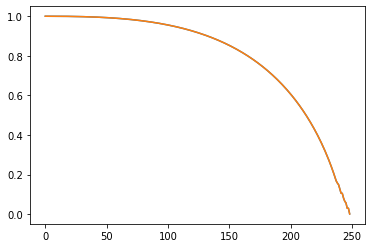

In [11]:
S0 = pdr.get_data_yahoo('SPY', start='2020-03-04', end='2020-03-05')['Close'][0] # SPY's closing price on March 4,2020.
print(S0)
K1 = 315
K2 = 320
Smin = 0
Smax = 500
M = 250
T = 7/12
N = 4000
spread = Euler_discretization(S0,K1,K2,Smin,Smax,M,T,N,r,sigma,right=False)
spread_right = Euler_discretization(S0,K1,K2,Smin,Smax,M,T,N,r,sigma,right=True)
print(spread)
print(spread_right)
print(spread_right - spread)